In [1]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
import random
import sklearn
from sklearn.model_selection import GridSearchCV
%xmode plain

Exception reporting mode: Plain


In [2]:
def mahalanobis_transformation(feature_df, flag = "Train"):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    if flag == "Train":
        globals()['feature_mean'] = np.array(feature_df.mean()).reshape(-1, 1).T # 1 * p
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_df.shape[0]
        # u, s, vh = np.linalg.svd(cov) # all real numbers
        s, u = np.linalg.eigh(cov) # all real numbers
        # w, v = np.linalg.eig(cov) # generate complex numbers
        # theshold for pinv: 1e-15
        s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
        s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        globals()['sigma_pinv_sqrt'] = u @ np.diag(s_pinv_sqrt) @ u.T
        feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    else:
        feature_df_whitened = (feature_df - ones @ globals()['feature_mean']) @ globals()['sigma_pinv_sqrt']
    return feature_df_whitened

def my_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):

    def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_centered.shape[0]
        return cov
    
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        # get slices
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()["feature_df_" + str(i + 1)] = feature_df_whitened.loc[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((cov_1.shape[0], cov_1.shape[0])), 
            columns = np.arange(feature_df.shape[1], dtype = int), 
            index = globals()['cov_' + str(1)].index
        )
        for i in np.arange(5):
            print('-------------------------------------------------------------------')
            print(f'Class label {str(i + 1)}:')
            print('COV Mat:')
            print(globals()['cov_' + str(i + 1)])
            if feature_df.shape[1] == 2:
                # u, s, vh = np.linalg.svd(globals()['cov_' + str(i + 1)])
                u, s = np.linalg.eigh(globals()['cov_' + str(i + 1)])
                print(f'Eigen values of COV mat: {s}')
                print(f'Eigen values ratio of COV mat: {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of COV mat) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of COV mat)^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')
                # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                s, u = np.linalg.eigh(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                print(f'Eigen values of (I - COV mat): {s}')
                print(f'Eigen values ratio of (I - COV mat) : {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of (I - COV mat)) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of (I - COV mat))^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')

            # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            s, u = np.linalg.eigh(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            print(f'(I - V) eigenvalues: {s}')
            # u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            s, u = np.linalg.eigh((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            print(f'(I - V)^2 eigenvalues: {s}')
            weighted_cov += weight_df.loc[i + 1] * (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T
        # u, s, vh = np.linalg.svd(weighted_cov)
        s, u = np.linalg.eigh(weighted_cov)
        print('-------------------------------------------------------------------')
        print(f'Weighted sum of (I - V)^2 eigenvalues: {s}')
        print('-------------------------------------------------------------------')
        globals()['directions'] = u[:,:n_directions]
        feature_df_reduced = feature_df_whitened @ directions
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced, feature_df_whitened

def sliced_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):
    from sliced import SlicedAverageVarianceEstimation
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        # feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        feature_df_whitened = feature_df
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        globals()['save'] = SlicedAverageVarianceEstimation(n_directions = n_directions, n_slices = 5)
        globals()['save'].fit(feature_df, label_df)
        globals()['directions'] = globals()['save'].directions_
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}') 
        return feature_df_reduced, feature_df_whitened
    else:
        # feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_whitened = feature_df
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
        return feature_df_reduced, feature_df_whitened

def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = None, 
    add_predictors = False, 
    n_directions = 977
):
    '''
    Implement sufficient dimension reduction methods. 
    SAVE
    Contour regression
    '''
    %xmode plain
    import pandas as pd
    import re
    import os
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if method:
        feature_df_reduced, feature_df_whitened = method(
            feature_df = feature_df, 
            label_df = label_df, 
            flag = flag,
            n_directions = n_directions
        )
        feature_df_reduced = pd.DataFrame(feature_df_reduced)
        return feature_df_reduced, feature_df_whitened
    else:
        print("No method specified")
        pass


def sanity_check(size = 1000, core_dirs = 1, feature_df_flag = False, feature_df = None, core_distribution = np.random.uniform, redundant_dirs = 1, n_directions = 1, fig_output = True, **kwargs):
    if feature_df_flag == False:
        core_feature_df = pd.DataFrame(data = None)
        for i in np.arange(core_dirs):
            core_feature_df = pd.concat(
                [
                    core_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * 5)
                ], 
                axis = 1
            )
        core_coef = np.random.random(size = core_dirs) * 0.1
        y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
        y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
        redundant_feature_df = pd.DataFrame(data = None)
        for i in np.arange(redundant_dirs):
            redundant_feature_df = pd.concat(
                [
                    redundant_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * (np.random.randint(10) + 5))
                ], 
                axis = 1
            )

    if feature_df_flag == False:
        syncthetic_feature_df_train = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    else:
        syncthetic_feature_df_train = feature_df
    syncthetic_label_df_train = pd.DataFrame(y_train_discrete, columns = ["label"])

    feature_df_reduced, feature_df_whitened = post_process(
        feature_df = syncthetic_feature_df_train, 
        label_df = syncthetic_label_df_train, 
        flag = "Train", 
        method = my_SAVE, 
        n_directions = n_directions
    )
    if fig_output:
        fig = plt.figure(figsize = (4,4), dpi = 270)
        ax = fig.add_subplot(projection = '3d')
        ax.scatter(
            feature_df_whitened.iloc[:,0], 
            feature_df_whitened.iloc[:,1], 
            y_train_discrete.reshape(-1, 1), 
            cmap = "inferno", 
            s = 4, 
            linewidths = 0, 
            edgecolors = None, 
            c = y_train_discrete.reshape(-1, 1))
        ax.set_xlabel("core_x1")
        ax.set_ylabel("redundant_x1")
        ax.set_zlabel("y")
        ax.set_title("Core features: " + str(core_dirs) + " Redundant features: " + str(redundant_dirs))
        plt.show()
        plt.figure(figsize = (4, 3), dpi = 270)
        plt.scatter(core_feature_df.iloc[:,0], y_train_discrete, cmap = "inferno", c = y_train_discrete.reshape(-1, 1))
        plt.xlabel("core_x1")
        plt.ylabel("y")
        plt.title("Sectional View")
        plt.show()
    print('-------------------------------------------------------------------')
    print(f'Directions: \n{directions}')
    return feature_df_reduced, feature_df_whitened, syncthetic_label_df_train

In [ ]:
# feature_df_reduced, feature_df_whitened, label_df = sanity_check(core_dirs = 3, redundant_dirs = 7, n_directions = 3, low = 20, high = 100)

In [3]:
def my_lr(feature_df_train, feature_df_test, label_df_train, label_df_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    lr_params_grid = {
        'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1,3,5,10], 
        'tol': [1e-5, 1e-4, 1e-3, 1e-2], 
        'penalty': ['elasticnet'],  
        'solver': ['saga'], 
        'random_state': [42], 
        'max_iter': [200, 400, 600, 1000], 
        'verbose': [0], 
        'n_jobs': [-1], 
        'l1_ratio': [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1]
    }

    gs_lr = GridSearchCV(
        estimator = LogisticRegression(), 
        param_grid = lr_params_grid, 
        cv = 5, 
        scoring = 'accuracy', 
        verbose = 0, 
        n_jobs = 6
    )
    gs_lr.fit(feature_df_train, np.array(label_df_train).ravel())
    best_lr = gs_lr.best_estimator_
    lr_pred = best_lr.predict(feature_df_test)
    lr_f1 = f1_score(y_true = label_df_test, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = label_df_test, y_pred = lr_pred)
    print('Best params: ')
    print(gs_lr.best_params_)
    print(f'Accuracy: {lr_accu:8.4f}\nF1-score: {lr_f1:8.4f}')
    print('-------------------------------------------------------------------')
    return lr_f1, lr_accu

In [4]:
def plot_learning_curve(n_directions_list, f1_score_list, accu_score_list, baseline_f1, baseline_accu, n_relevant_feature, metric_name, x_name, title, x_scale = "linear", save = False, filepath = "", filename = ""):
    '''
    Input: x-axis (e.g. PCA directions kept / n_estimators / max_depth)
           metric_name for y-axis (e.g. misclassification error / crossentropy error / accuracy / f1 score)
           title for this axis
           training + validation score in list
           default in linear scale
           default no saving files, if save is True, then have to specify filename and file path
    Output: inline display of the learning curve
    '''
    import pandas as pd
    import numpy as np  
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import cm
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    fig,ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.axvline(x = n_relevant_feature, alpha = 0.4, c = [56 / 255, 56 / 255, 56 / 255], linewidth = 18)
    ax.text(x = n_relevant_feature - 0.5, y = 0.2, s = "n_relevant_features = " + str(n_relevant_feature))
    ax.plot(n_directions_list, f1_score_list, 'o-', label = "F1 score", linewidth = 2)
    ax.plot(n_directions_list, accu_score_list, 'o-', label = "Accuracy score", linewidth = 2)
    ax.axhline(y = baseline_f1, label = "Baseline F1", linestyle = '--', linewidth = 2, c = [255 / 255, 107 / 255, 107 / 255], alpha = 0.7)
    ax.axhline(y = baseline_accu, label = "Baseline Accuracy", linestyle = '--', linewidth = 2, c = [165 / 255, 190 / 255, 204 / 255], alpha = 0.7)
    ax.legend()
    ax.set_xscale(x_scale)
    ax.set_title('Learning Curve: ' + title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(metric_name)
    plt.show()
    if save:
        fig.savefig(filepath + filename + ".png", format = "png")
    pass

In [5]:
# generate feature_df for reuse
def generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 2500, test_size = 0.2, core_distribution = np.random.multivariate_normal, **kwargs): # different dist
    import pandas as pd
    import numpy as np
    import random
    from sklearn.model_selection import train_test_split

    total_features = core_dirs + redundant_dirs
    mean_vec = np.random.random(size = total_features) * 10
    feature_df = pd.DataFrame(core_distribution(size = size, mean = mean_vec, **kwargs)) # specify mean + cov
    core_coef = np.random.random(size = core_dirs) + 0.5
    redundant_coef = np.zeros((redundant_dirs))
    coef = np.concatenate([core_coef, redundant_coef], axis = 0)
    y_train = np.sin(0.2 * np.asarray(feature_df) @ coef) * 10 + np.random.random(size = size)   
    y_train_discrete = pd.cut(y_train, bins = 5, labels = np.arange(5) + 1).astype(int)
    synthetic_feature_df = feature_df
    synthetic_label_df = pd.DataFrame(y_train_discrete, columns = ["label"])
    synthetic_feature_df_train, synthetic_feature_df_test, synthetic_label_df_train, synthetic_label_df_test = train_test_split(
        synthetic_feature_df, synthetic_label_df, 
        test_size = test_size, 
        shuffle = True, 
        random_state = 42
    )
    return synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test


In [6]:
def lr_learning_curve(synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test, method = my_SAVE):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    n_directions_list = list(np.arange(1, synthetic_feature_df_train.shape[1] + 1, dtype = int))
    f1_list = []
    accu_list = []

    for n_direction in n_directions_list:
        print(f'n_directions: {n_direction}')
        globals()['feature_df_reduced_' + str(n_direction) + "_train"], synthetic_feature_df_train_whitened = post_process(
            synthetic_feature_df_train, 
            synthetic_label_df_train, 
            flag = "Train", 
            method = method, 
            add_predictors = False, 
            n_directions = n_direction
        )
        globals()['feature_df_reduced_' + str(n_direction) + "_test"], synthetic_feature_df_test_whitened = post_process(
            synthetic_feature_df_test, 
            synthetic_label_df_test, 
            flag = "Test", 
            method = method, 
            add_predictors = False, 
            n_directions = n_direction
        )
        curr_test_f1, curr_test_accu = my_lr(
            feature_df_train = globals()['feature_df_reduced_' + str(n_direction) + "_train"], 
            feature_df_test = globals()['feature_df_reduced_' + str(n_direction) + "_test"], 
            label_df_train = synthetic_label_df_train, 
            label_df_test = synthetic_label_df_test
        )
        f1_list.append(curr_test_f1)
        accu_list.append(curr_test_accu)

    # train w/ original features -> syncthetic_feature_df -> whitened
    baseline_test_f1, baseline_test_accu = my_lr(
            feature_df_train = synthetic_feature_df_train_whitened, 
            feature_df_test = synthetic_feature_df_test_whitened, 
            label_df_train = synthetic_label_df_train, 
            label_df_test = synthetic_label_df_test
    )
    return f1_list, accu_list, baseline_test_f1, baseline_test_accu, n_directions_list


In [7]:
def train_loop(core_dirs, redundant_dirs, size = 2500, test_size = 0.2, n_iteration = 10, save = True, suffix = ""):
    if save:
        if suffix == "":
            raise ValueError("No filename suffix assigned!")
    total_features = core_dirs + redundant_dirs
    columns_list = list(np.arange(1, total_features + 1, dtype = int))
    columns_list.append("baseline")
    f1_df = pd.DataFrame(data = None, columns = columns_list)
    accu_df = pd.DataFrame(data = None, columns = columns_list)
    for i in np.arange(n_iteration):
        f1_list, accu_list = [], []
        # cov = np.diag(np.random.random(size = total_features) * 10)
        cov = np.eye(total_features)
        synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test = generate_synthetic_data(
            core_dirs = core_dirs, 
            redundant_dirs = redundant_dirs, 
            size = size, 
            test_size = test_size, 
            core_distribution = np.random.multivariate_normal, 
            cov = cov
        )
        f1_list, accu_list, baseline_f1, baseline_accu, n_directions_list = lr_learning_curve(
            synthetic_feature_df_train, 
            synthetic_label_df_train, 
            synthetic_feature_df_test, 
            synthetic_label_df_test
        )
        f1_list.append(baseline_f1)
        accu_list.append(baseline_accu)
        f1_df = pd.concat([f1_df, pd.DataFrame([f1_list], columns = f1_df.columns, index = [i])], axis = 0)
        accu_df = pd.concat([accu_df, pd.DataFrame([accu_list], columns = f1_df.columns, index = [i])], axis = 0)

    if save:
            f1_df.to_csv("../output/f1_df_" + suffix + ".csv", header = True)
            accu_df.to_csv("../output/accu_df_" + suffix + ".csv", header = True)

    return f1_df, accu_df

In [8]:
f1_df, accu_df = train_loop(4, 6, size = 2500, test_size = 0.2, n_iteration = 5, save = True, suffix = "ver4")

n_directions: 1
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.015572  0.001018  0.033658  0.035826  0.958682  0.036665   
6 -0.002008  0.002842 -0.031133  0.007091  0.030592  0.036665  0.993577   
7 -0.003872  0.007739  0.041190  0.009224 -0.034552 -0.004358  0.003944   
8 -0.010248  0.002630  0.024284 -0.004339 -0.013462 -0.003479 

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 2
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 3
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 4
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 5
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 6
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 7
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 8
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 9
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.5600
F1-score:   0.1436
-------------------------------------------------------------------
n_directions: 10
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.749725 -0.131760 -0.234425 -0.140518 -0.029579  0.008421 -0.002008   
1 -0.131760  0.887308 -0.092922 -0.071182  0.034261  0.015572  0.002842   
2 -0.234425 -0.092922  0.861896 -0.119011 -0.015443  0.001018 -0.031133   
3 -0.140518 -0.071182 -0.119011  0.946845  0.024302  0.033658  0.007091   
4 -0.029579  0.034261 -0.015443  0.024302  0.981946  0.035826  0.030592   
5  0.008421  0.

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 10, 'l1_ratio': 1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.9340
F1-score:   0.7254
-------------------------------------------------------------------


/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 10, 'l1_ratio': 1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.9340
F1-score:   0.7254
-------------------------------------------------------------------
n_directions: 1
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5562

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 2
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 3
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 4
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 5
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 6
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 7
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 8
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 9
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.5

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8180
F1-score:   0.1800
-------------------------------------------------------------------
n_directions: 10
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  6.718061  3.708228  3.893640  3.720134  0.678188 -1.007697 -1.201386   
1  3.708228  2.046864  2.149207  2.053436  0.374346 -0.556228 -0.663140   
2  3.893640  2.149207  2.256667  2.156108  0.393063 -0.584039 -0.696297   
3  3.720134  2.053436  2.156108  2.060029  0.375548 -0.558014 -0.665269   
4  0.678188  0.374346  0.393063  0.375548  0.068463 -0.101727 -0.121280   
5 -1.007697 -0.

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which

Best params: 
{'C': 3, 'l1_ratio': 0.8, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8200
F1-score:   0.1972
-------------------------------------------------------------------


/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 3, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.8200
F1-score:   0.1972
-------------------------------------------------------------------
n_directions: 1
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.000103

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 2
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 3
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 4
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 5
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 6
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 7
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 8
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 9
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.0001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.7420
F1-score:   0.1704
-------------------------------------------------------------------
n_directions: 10
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.810798 -0.192447 -0.146694 -0.123717  0.004610  0.020774  0.002448   
1 -0.192447  0.839723 -0.130755 -0.140821  0.016354 -0.000103 -0.019125   
2 -0.146694 -0.130755  0.883344 -0.084356  0.010694 -0.001737 -0.022350   
3 -0.123717 -0.140821 -0.084356  0.934009 -0.006437  0.014723 -0.000101   
4  0.004610  0.016354  0.010694 -0.006437  1.023833 -0.018335 -0.007932   
5  0.020774 -0.

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 3, 'l1_ratio': 1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05, 'verbose': 0}
Accuracy:   0.9140
F1-score:   0.6543
-------------------------------------------------------------------


In [60]:
# f1_df = pd.read_csv("../output/f1_df_ver1.csv", header = 0)
# f1_df.drop(["Unnamed: 0"], axis = 1, inplace = True)
# accu_df = pd.read_csv("../output/accu_df_ver1.csv", header = 0)
# accu_df.drop(["Unnamed: 0"], axis = 1, inplace = True)

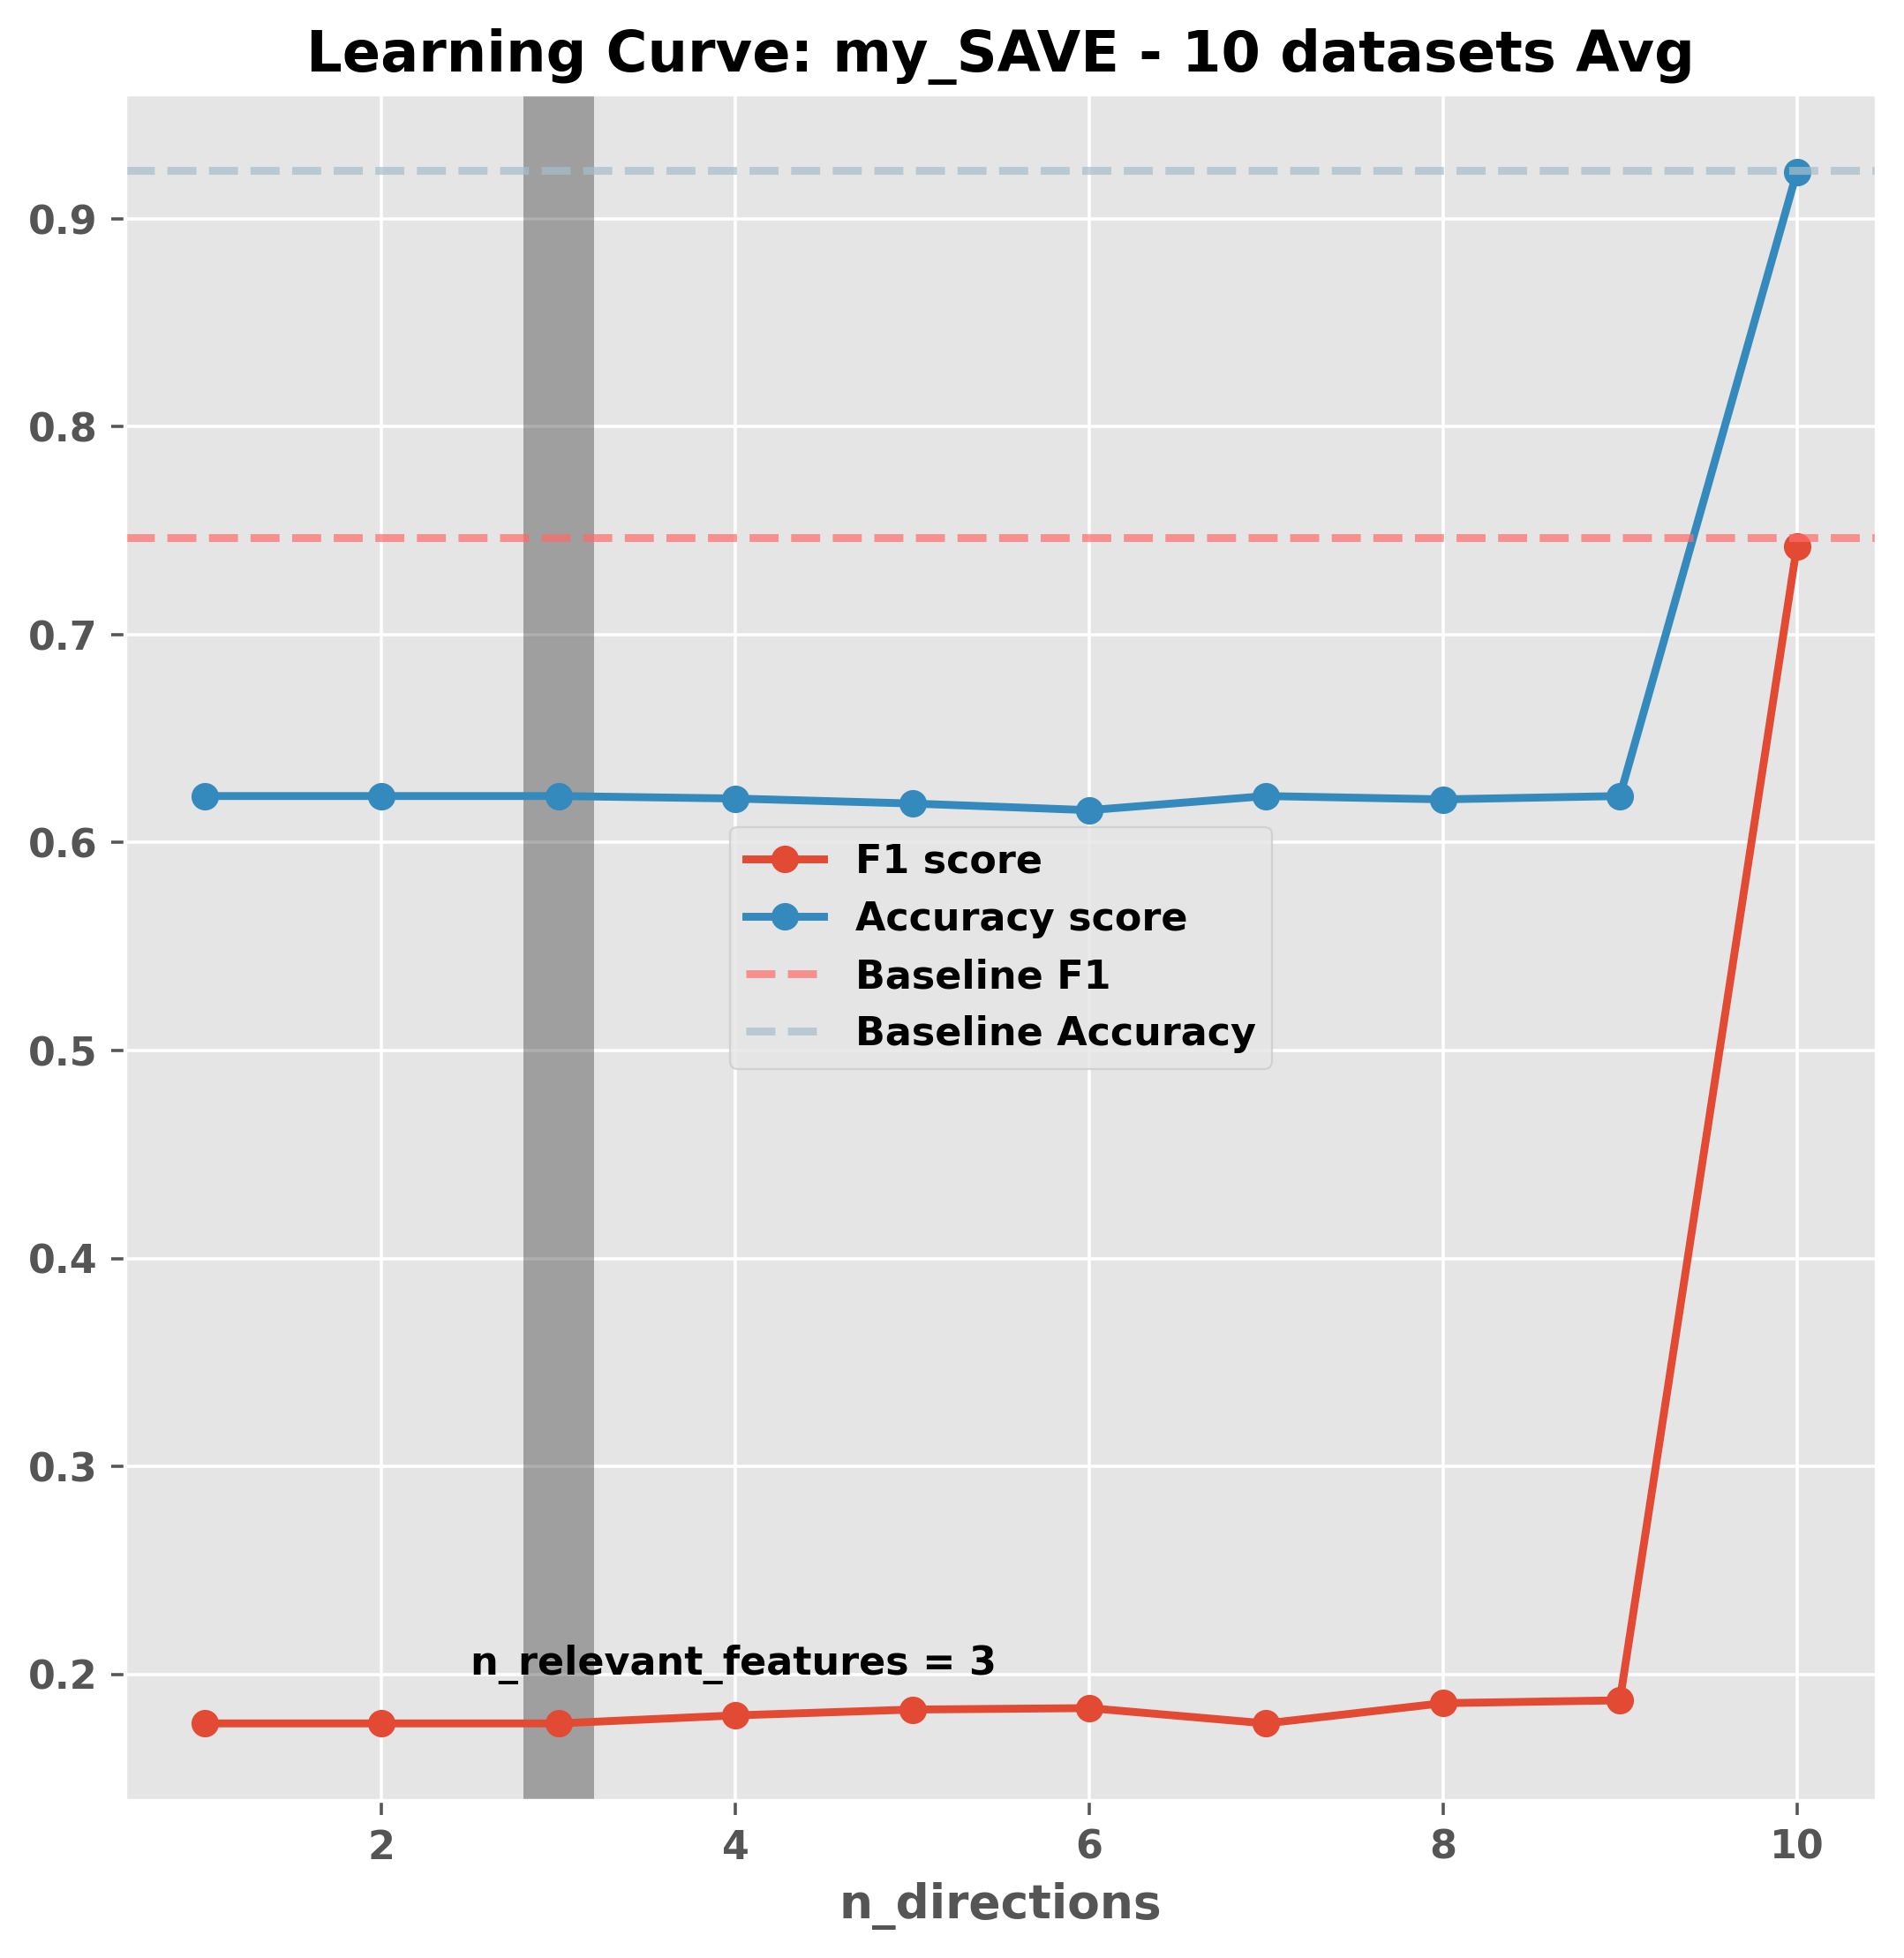

In [16]:
plot_learning_curve(
    n_directions_list = np.arange(1,11), 
    f1_score_list = list(f1_df.mean()[:10]), 
    accu_score_list = list(accu_df.mean()[:10]), 
    baseline_f1 = f1_df.mean()["baseline"], 
    baseline_accu = accu_df.mean()["baseline"],
    n_relevant_feature = 3,
    metric_name = "", 
    x_name = "n_directions", 
    title = "my_SAVE - 10 datasets Avg"
)